❗ Оставлены рекомендации ревьюера

# Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.   
  
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).  
  
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.  
  
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных

Данные состоят из файлов, полученных из разных источников:  
  
- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).
  
Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Этап 1. Подготовка и анализ исходных данных

In [ ]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import warnings
warnings.filterwarnings('ignore')

from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
try:
    arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
except:
    arc = pd.read_csv('C://Users//Yukat//Desktop//final_steel//data_arc.csv')
    bulk = pd.read_csv('C://Users//Yukat//Desktop//final_steel//data_bulk.csv')
    bulk_time = pd.read_csv('C://Users//Yukat//Desktop//final_steel//data_bulk_time.csv')
    gas = pd.read_csv('C://Users//Yukat//Desktop//final_steel//data_gas.csv')
    temp = pd.read_csv('C://Users//Yukat//Desktop//final_steel//data_temp.csv')
    wire = pd.read_csv('C://Users//Yukat//Desktop//final_steel//data_wire.csv')
    wire_time = pd.read_csv('C://Users//Yukat//Desktop//final_steel//data_wire_time.csv')

Так как таблиц много, напишем для всех функцию для просмотра первых пяти строк и информации о таблицах.

In [ ]:
def view_info(data):
    display(data.head(5))
    print(data.info())
    print(data.describe())

### Электроды

In [ ]:
view_info(arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.670441             0.452592
std      934.571502           0.408159             5.878702
min        1.000000           0.030002          -715.504924
25%      806.000000           0.395297             0.290991
50%     1617.000000           0.555517             0.415962
75%     2429.000000           0.857034        

Пропусков нет, однако дата хранится в формате object, сразу поправим

In [ ]:
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'])
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'])

arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Далее посмотрим на распределения мощностей

Text(0.5, 0, 'Активная мощность')

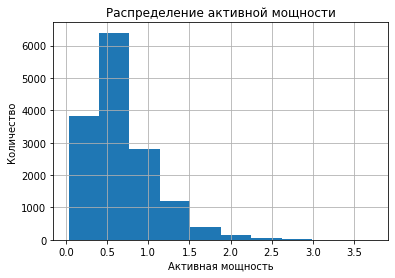

In [ ]:
plt.figure()

ax = arc['Активная мощность'].hist()
ax.set_title('Распределение активной мощности')
ax.set_ylabel('Количество')
ax.set_xlabel('Активная мощность')

Text(0.5, 0, 'Реактивная мощность')

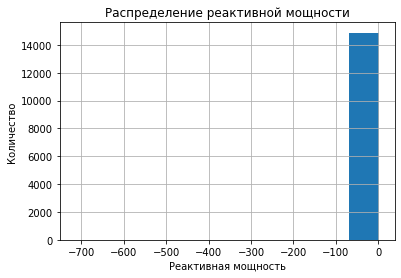

In [ ]:
plt.figure()

ax = arc['Реактивная мощность'].hist()
ax.set_title('Распределение реактивной мощности')
ax.set_ylabel('Количество')
ax.set_xlabel('Реактивная мощность')

В столбце Реактивная мощность есть отрицательные значения, а минимальное аж -715.
Я нашла инфо, что реактивная мощность может быть отрицатьной (https://khomovelectro.ru/articles/aktivnaya-reaktivnaya-i-polnaya-kazhushchayasya-moshchnosti.html), но график распределения выглядит странно, это похоже на выброс.

Посмотрим сколько в принципе есть значений меньше нуля

In [ ]:
arc[arc['Реактивная мощность'] <= 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Такое значение только одно, это выброс. В пункте предобработки решим, каким образом можно будет от него избавиться.  

Text(0.5, 0, 'Реактивная мощность')

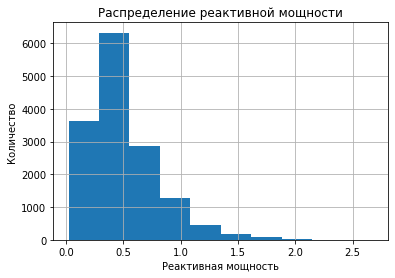

In [ ]:
plt.figure()

ax = arc[arc['Реактивная мощность'] > 0]['Реактивная мощность'].hist()
ax.set_title('Распределение реактивной мощности')
ax.set_ylabel('Количество')
ax.set_xlabel('Реактивная мощность')

Без этого выброса распределение выглядит адекватно, аномалий нет.  
  
Посмотрим, сколько итераций нагрева чаще всего бывает на одну партию

Text(0.5, 0, 'Количество итераций нагрева')

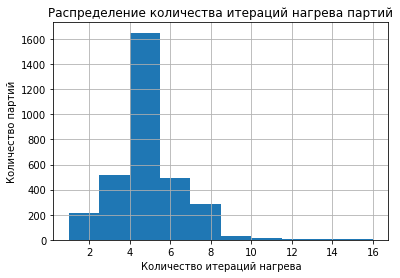

In [ ]:
plt.figure()

ax = arc.groupby('key')['Активная мощность'].count().hist()
ax.set_title('Распределение количества итераций нагрева партий')
ax.set_ylabel('Количество партий')
ax.set_xlabel('Количество итераций нагрева')

На одну партию чаще приходится 5 итераций, реже - 4 или 6

### Сыпучие материалы (объём)

In [ ]:
view_info(bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
               key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   

В таблице много пропусков. Наверное, они означают то, что какой-либо сыпучий материал не использовался в процессе производства той или иной партии.  
Думаю, их можно будет на нули заменить потом.  
  
Посмотрим на распределения. Нарисуем гистограммы циклом

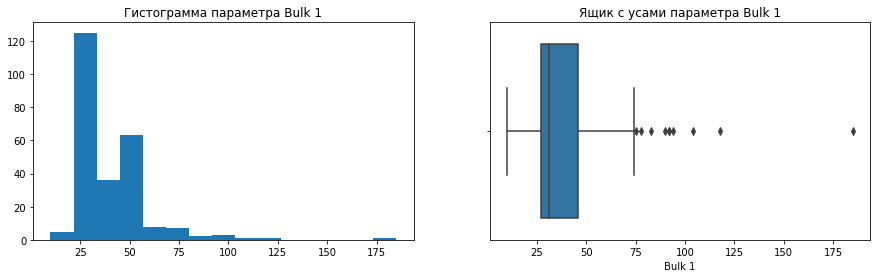

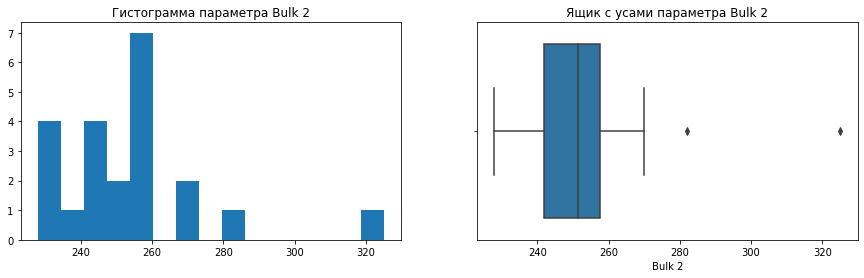

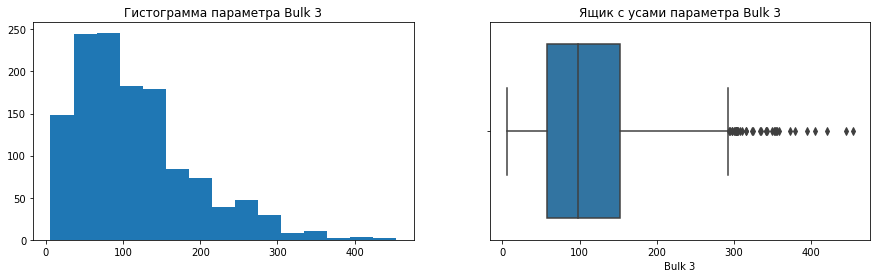

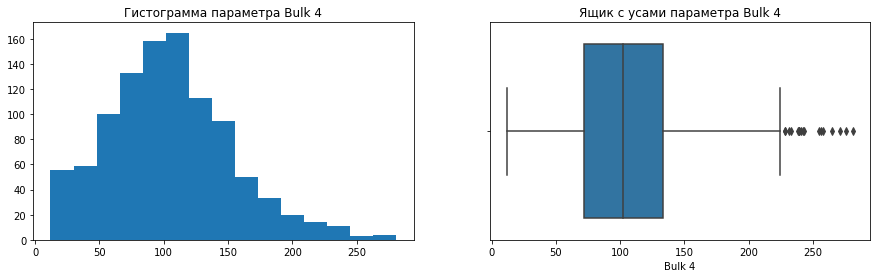

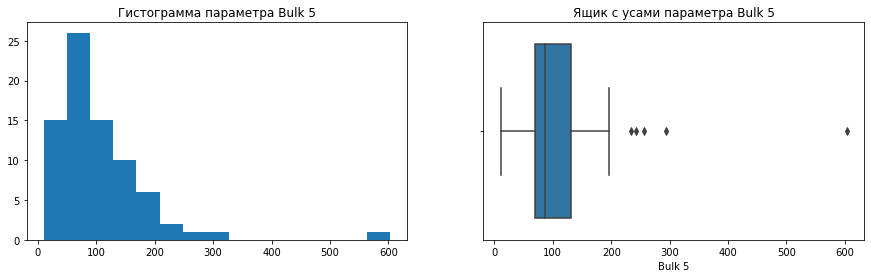

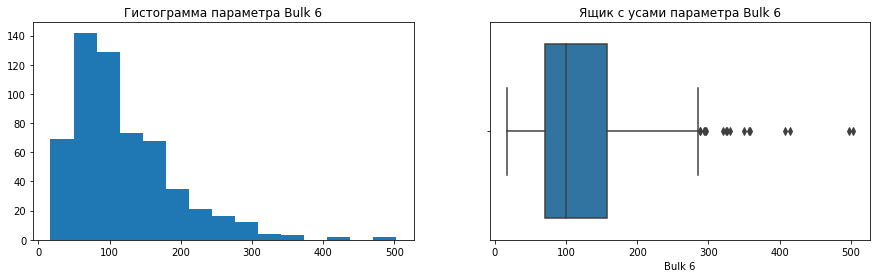

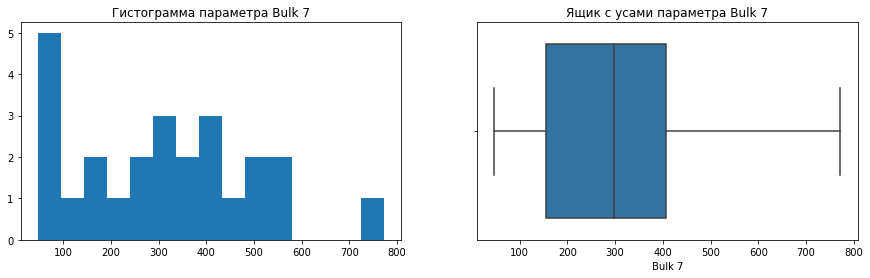

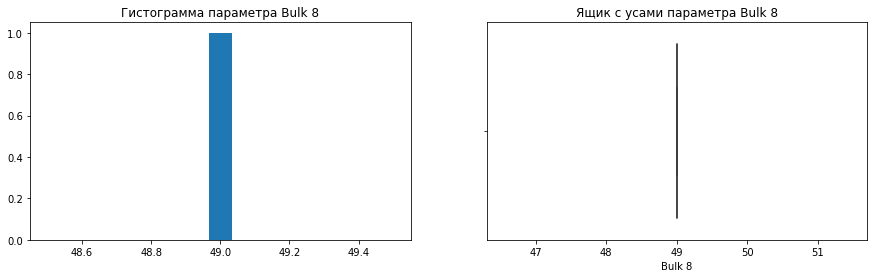

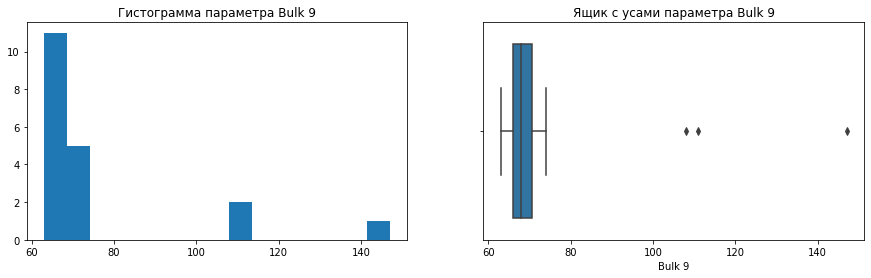

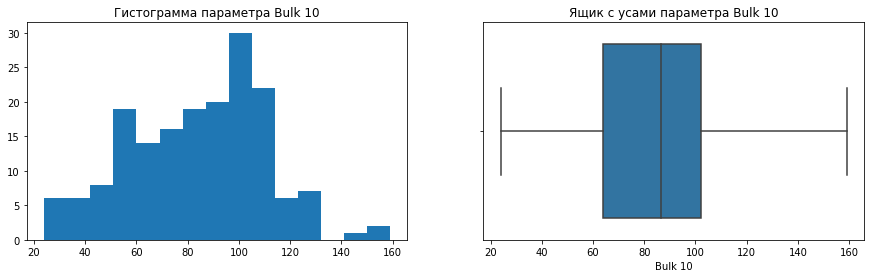

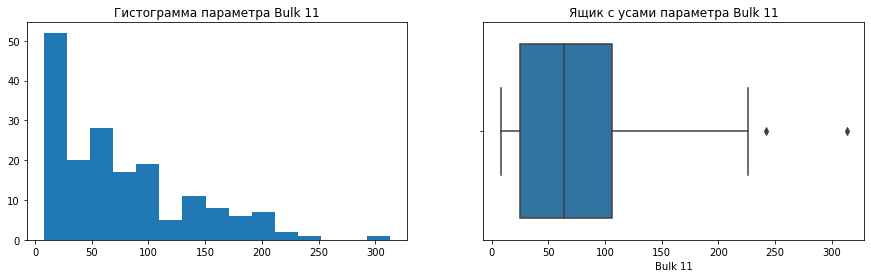

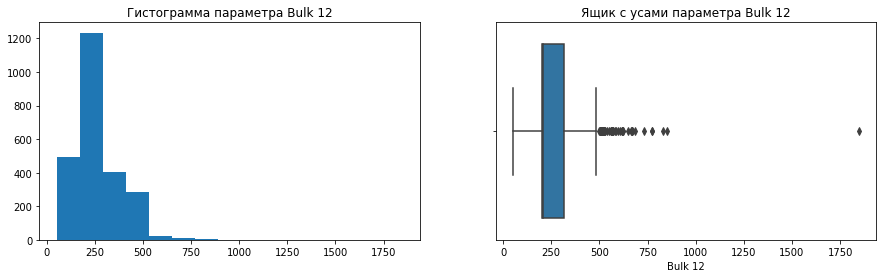

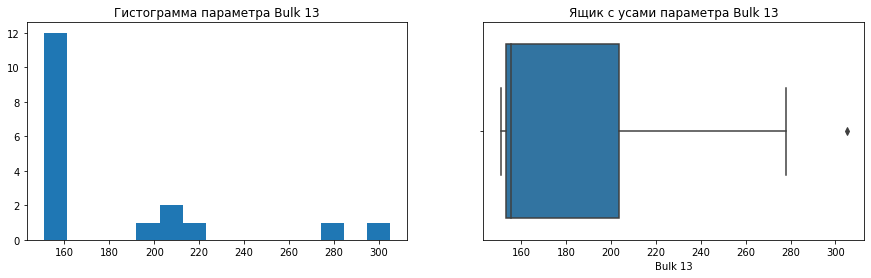

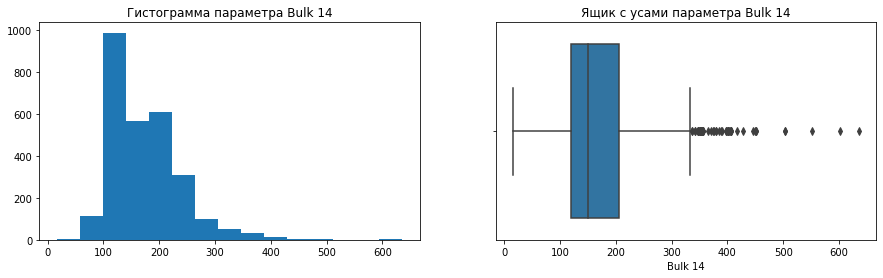

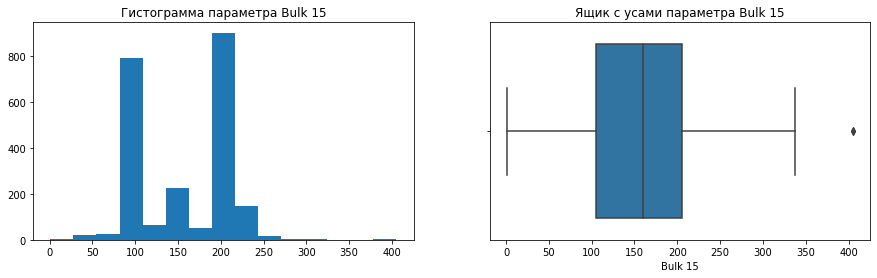

In [ ]:
columns_list = list(bulk)
columns_list.remove('key')


for parameter in columns_list:
    fig, axs = plt.subplots(1,2, figsize=(15,4))

    axs[0].hist(x=bulk[parameter],
            bins=15,
            linewidth=1)

    axs[0].set_title(f'Гистограмма параметра {parameter}')

    sns.boxplot(x=bulk[parameter],
                orient='v',
                width=0.8)

    axs[1].set_title(f'Ящик с усами параметра {parameter}')

plt.show()

Каких-то явных аномалий, как в предыдущей таблице, не наблюдается.

### Сыпучие материалы (время)

In [ ]:
view_info(bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None
               key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.00000

На консультации решили, что таблица некорректная и использовать мы её не будем. Поэтому не будем строить распределение.  
  
Единственное, что можно тут сказать - это то, что пропуски тут вероятнее всего такой же природы как и в предыдущей:там, где сыпучий материал не использовался

### Продувка сплава газом

In [ ]:
view_info(gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040


Text(0.5, 0, 'Значение')

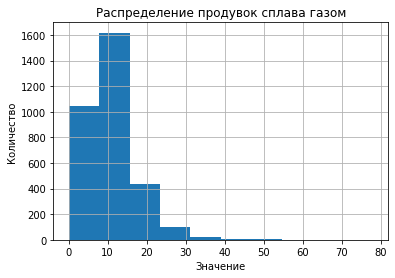

In [ ]:
plt.figure()

ax = gas['Газ 1'].hist()
ax.set_title('Распределение продувок сплава газом')
ax.set_ylabel('Количество')
ax.set_xlabel('Значение')

Данные выглядят адекватно, аномалий тоже нет. Пик приходится на 9-15 продувок.  
Предобработка этой таблице не требуется

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>
    <p>ОК. Кстати, если параметр bins менять, то рисунок иной может быть) И особые точки более рельефно видны. Вот ниже пример:</p>
</div>

Text(0.5, 0, 'Значение')

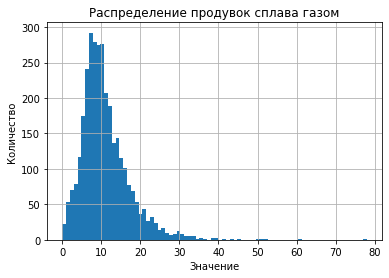

In [ ]:
plt.figure()

ax = gas['Газ 1'].hist(bins=80)
ax.set_title('Распределение продувок сплава газом')
ax.set_ylabel('Количество')
ax.set_xlabel('Значение')

### Результаты измерения температуры

In [ ]:
view_info(temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None
                key   Температура
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241.000000   1705.000000


Здесь снова время неверного формата, поправим

In [ ]:
temp['Время замера'] = pd.to_datetime(temp['Время замера'])

temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


Ещё можно заметить, что есть пропуски в значениях температуры. Если пропуска удалять, то придётся сносить все партии.
Посмотрим на уникальные номера партий, где есть хотя бы один пропуск.

In [ ]:
temp[temp['Температура'].isnull()]['key'].unique()

array([2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510,
       2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521,
       2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532,
       2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543,
       2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554,
       2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565,
       2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576,
       2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587,
       2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598,
       2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609,
       2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620,
       2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631,
       2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642,
       2643, 2644, 2645, 2646, 2647, 2648, 2649, 26

Пропуски есть в каждой партии, начиная от 2500. Возможно была какая-то неполадка на производсве.
Далее при предобработке данных удалим все партии.

Text(0.5, 0, 'Количество измерений')

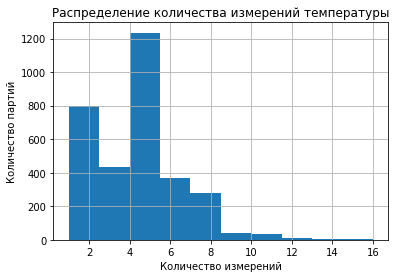

In [ ]:
plt.figure()

ax = temp.groupby('key')['Температура'].count().hist()
ax.set_title('Распределение количества измерений температуры')
ax.set_ylabel('Количество партий')
ax.set_xlabel('Количество измерений')

Количество измерений температуры варьируется от 1 до 16

### Проволочные материалы (объём)

In [ ]:
view_info(wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
               key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15

In [ ]:
wire = wire.drop('Wire 5',axis=1)

Таблица по структуре очень похожа на таблицу с сыпучими материалами. Природа пропусков, полагаю, здесь такая же: если проволочный материал в партии не использовался, то ставится пропуск

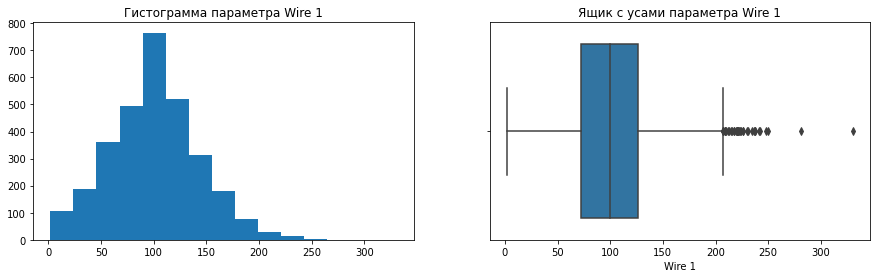

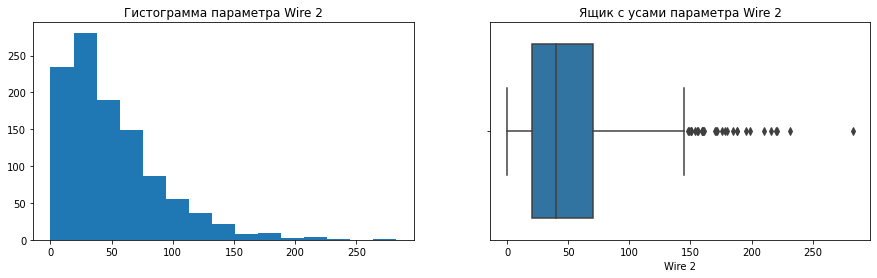

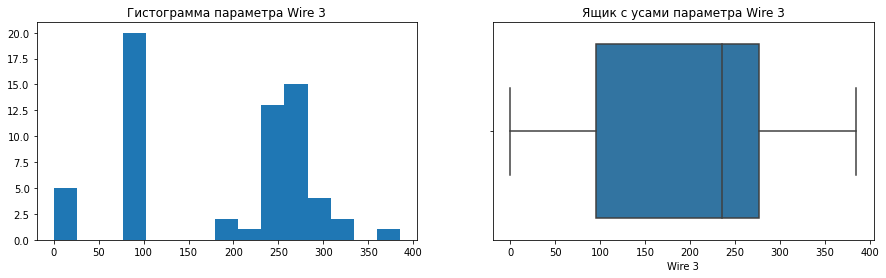

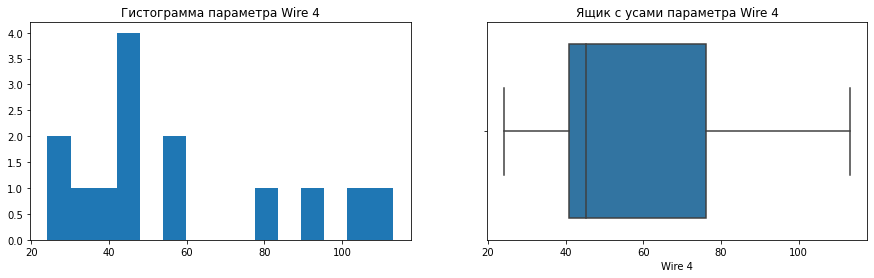

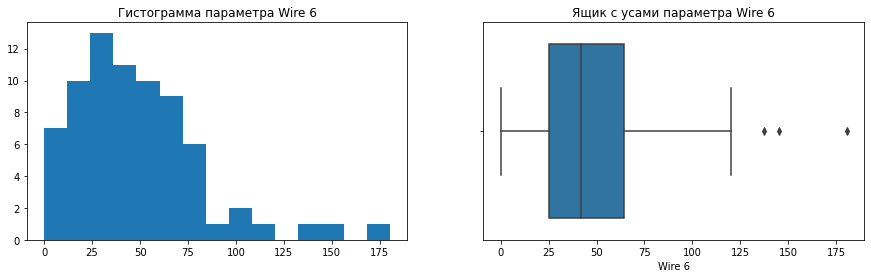

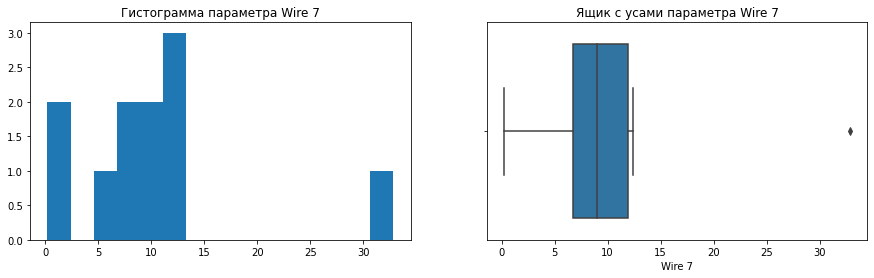

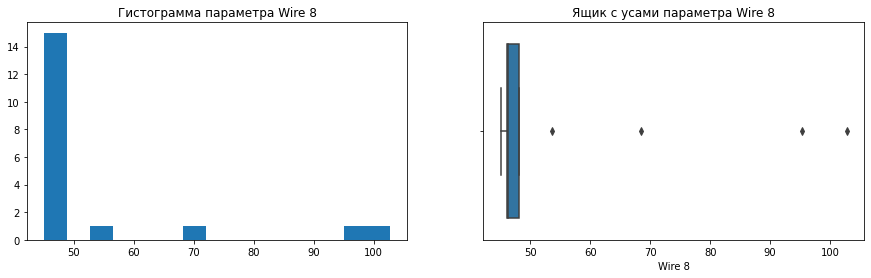

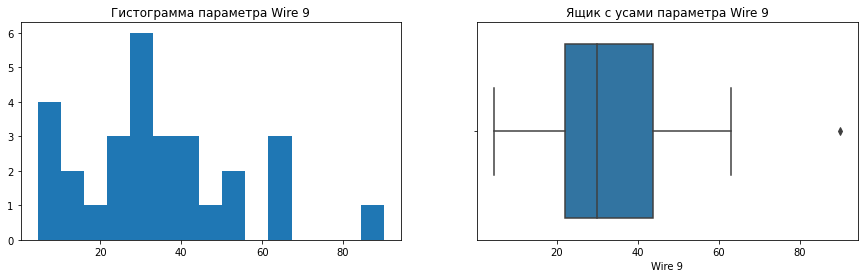

In [ ]:
columns_list = list(wire)
columns_list.remove('key')


for parameter in columns_list:
    fig, axs = plt.subplots(1,2, figsize=(15,4))

    axs[0].hist(x=wire[parameter],
            bins=15,
            linewidth=1)

    axs[0].set_title(f'Гистограмма параметра {parameter}')

    sns.boxplot(x=wire[parameter],
                orient='v',
                width=0.8)

    axs[1].set_title(f'Ящик с усами параметра {parameter}')

plt.show()

Явных аномальных значений здесь нет. Пропуски же мы можем заполнить нулями

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>ящик с усами покахывает некие выбросы. Но с выбросами тут действительно важный момент. Ведь выброс выбросу рознь) Бывает, что выброс - то реальная бизнес-практика. И если удалить их, то мы получим модель, так скажем, работующую не во всех диапазонах входящих в неё факторов. Т.е. по метрикам модель будет хорошая. А вот по бизнесу - не совсем применимая.<br>А бывают выбросы - точно выбросы - ошибки учёта данных, например.<br>
    
В самой теории выбросов принято считать, что выбросы в интервале от q_3 + 1.5*irq до q_3 + з*irq - на усмотрение бизнеса. А вот всё, что больше q_3 + 3*irq - уже точно надо работать - на удаление!!!<br>
q_3 - верхняя квартиль<br>
irq - интерквартильный размах

В таких проектах, также лучше использовать такую философию анализа выбросов:<br>
Ящик с усами - даёт пищу для размышлений (не более того, не воспринимаем его как сигнал к действию).<br>
А потом смотрим то явление, что изучаем. Данные значения - могут быть в реальности или нет?<br>
Вот, например, в случае с температурой плавления: по справочнику она у металла = около 1400+-, т.е. 1200 - действиетльно кажется очень странным значением. А 1450 выглядит вполне рабочим. Поэтому, согласен с твоими выводами выше.

### Проволочные материалы (время)

In [ ]:
view_info(wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
               key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000


Здесь таблица аналогичная bulk_time, только с другими присадками. Договорились, что она некорректная и пользоваться мы ей не будем.  
Пропуски образовались здесь потому, что какие-то проволочные материалы не использовались в конкретной партии.

### Выводы по 1 этапу

1. В таблицах разное количество уникальных номеров партии key. Это может означать, что данные по партии могут быть утеряны или над ней не выполнялся технологический этап.  
  
2. В таблицах с присадками и температурой есть пропуски. В таблицах с присадками они обусловлены технологическим процессом: некоторые присадки не использовалась в каких-либо партиях, такие пропуски можем заменить нулями. В таблице с температурой пропуски встречаются во всех партиях начиная с 2500. Они могут быть обусловлены, например, неисправностью датчика, который должен температуру передавать и по какой-то причине перестал справляться с этим.  
  
3. Во всех таблицах даты записаны в формате object. В таблицах с электродами и температурой тип данных сразу поменяли на нужный. Таблицы с присадками трогать не стали, так как считаем, что данные в них некорректны и использовать их не будем.  
  
4. Столбцы записаны на русском языке, поменяем названия столбцов на корректное: на английском языке, используя снейк кейс.  
  
5. Одно аномальное значение реактивной мощности: огромное отрицательное число. Только от него мы не сможем избавиться, это будет некорректно, придётся избавляться от всей партии.  
  
6. Данные распределеные об активной и реактивной мощности распределены нормально со смещением влево.  
  
7. На одну партию чаще приходится 5 итераций нагрева, реже - 4 или 6  
  
8. Количество измерений температуры варьируется от 1 до 16 на одну партию

## План дальнейшей работы

1. Предобработка данных  
  
    * Удаляем партии с 2500 и выше, т.к. у них есть пропуски в температуре
    * Удаляем партию с аномальным значением реактивной мощности
    * Пропуски в таблицах с объёмами присадок заменяем на 0   
          
2. Добавление признаков:
    * Добавляем новый признак: полная мощность - корень из сумм квадратов активной и реактивной мощностей
    * Добаляем новый признак: энергия = полная мощность * время;
    * Добавляем новый признак: время нагрева, когда электроды были активны;
    * Добавляем новый признак: полная масса всех присадок для партии;
    * Добавляем новый признак: первая температура;
    * Выделяем целевой признак: последняя температура.
    * Промежуточные температуры удаляем, они не нужны
    * К таблице с целевым признаком присоединяем остальные признаки. В конце удаляем все партии без признаков, если нет присадок, если нет проволоки, если нет газа. Что-то одно должно быть  
      
3. Моделирование:
    * Проверить данные на коллинеарность, анализ важности факторов
    * Разделим данные на выборки, на тестовую будет приходиться 20%
    * Обучим CatBoostRegressor, LGBMRegressor, линейную регрессию. Используем кроссвалидацию
    * Проверим лучшие модели на тестовой выборке  
      
    
4. Написать отчёт

## 2 этап. Предобработка данных и моделирование

### Предобработка

Начнём с пропусков: заполним пропуски в таблицах с сыпучими материалами и проволоками.

In [ ]:
bulk = bulk.fillna(0)
wire = wire.fillna(0)

bulk.info()
display(wire.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  

None

Переименуем столбцы по правилам

In [ ]:
arc.columns = ['key', 'arc_heating_start', 'arc_heating_end', 'active_power', 'reactive_power']
gas.columns = ['key', 'gas']
temp.columns = ['key', 'datetime', 'temp']
wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 'wire_8', 'wire_9']
bulk.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

Удалим партию с аномальным значением

In [ ]:
arc = arc.query('key != 2116')
gas = gas.query('key != 2116')
temp = temp.query('key != 2116')
wire = wire.query('key != 2116')
bulk = bulk.query('key != 2116')

Удаляем партии с 2500

In [ ]:
temp =  temp.query('key < 2500')
arc = arc.query('key < 2500')
bulk = bulk.query('key < 2500')
wire = wire.query('key < 2500')
gas = gas.query('key < 2500')

Переходим к добавлению признаков:
      
1. Полная мощность: корень из сумм квадратов активной и реактивной мощностей

In [ ]:
arc['full_power'] = np.sqrt(arc['active_power']**2 + arc['reactive_power']**2)

2. Время нагрева, когда электроды были активны (в секундах)

In [ ]:
arc['heating_duration'] = (arc['arc_heating_end'] - arc['arc_heating_start']) // pd.Timedelta('1s')

3. Энергия (полная мощность * время)

In [ ]:
arc['energy'] = arc['full_power'] * arc['heating_duration']

In [ ]:
arc.head()

,key,arc_heating_start,arc_heating_end,active_power,reactive_power,full_power,heating_duration,energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228,272.149755
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185,177.416785
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172,154.118502
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365,719.221394
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148,119.471318


4. Температура  

In [ ]:
temp = temp.groupby(by = 'key').agg(['first', 'last']).reset_index()
temp.columns = temp.columns.droplevel()
temp.columns = ['key', 'start_time', 'end_time', 'start_temp', 'end_temp']
temp = temp[['key', 'start_temp', 'end_temp']]

temp

,key,start_temp,end_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2471,2495,1570.0,1591.0
2472,2496,1554.0,1591.0
2473,2497,1571.0,1589.0
2474,2498,1591.0,1594.0


5. Сумма присадок на партию  

В этом же пункте объединим данные в финальную таблицу и в ней самой посчитаем сумму

In [ ]:
arc = arc.groupby(by = 'key', as_index=False).sum()

arc.shape

(2474, 6)

In [ ]:
#df = (arc.merge(temp, how='left', on='key')
#         .merge(wire, how='left', on='key')
#         .merge(bulk, how='left', on='key')
#         .merge(gas, how='left', on='key'))

#df.shape

In [ ]:
df = (arc.merge(temp, how='inner', on='key')
         .merge(wire, how='inner', on='key')
         .merge(bulk, how='inner', on='key')
         .merge(gas, how='inner', on='key'))

df.shape

(2328, 32)

<div class="alert alert-warning" style="border-color: darkorange; border-radius: 5px">
    <p><u><b>⚠️ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>
    <p>Тут такой момент: при объединении могут появляться строки, где нет ни одной присадки или нет газа. Такие строки надо удалять. Т.к. с партией что-то должны делать). Нужно этот момент проверить. Возможно, что соединение по inner решит эту проблематику. Посмотри, пожалуйста. Сразу количество партий уменьшится)</p>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Проверила чуть ниже, действительно, помогло. Спасибо!
</div>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2327
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               2328 non-null   int64  
 1   active_power      2328 non-null   float64
 2   reactive_power    2328 non-null   float64
 3   full_power        2328 non-null   float64
 4   heating_duration  2328 non-null   int64  
 5   energy            2328 non-null   float64
 6   start_temp        2328 non-null   float64
 7   end_temp          2328 non-null   float64
 8   wire_1            2328 non-null   float64
 9   wire_2            2328 non-null   float64
 10  wire_3            2328 non-null   float64
 11  wire_4            2328 non-null   float64
 12  wire_6            2328 non-null   float64
 13  wire_7            2328 non-null   float64
 14  wire_8            2328 non-null   float64
 15  wire_9            2328 non-null   float64
 16  bulk_1            2328 non-null   float64


In [ ]:
df.head(10)

,key,active_power,reactive_power,full_power,heating_duration,energy,start_temp,end_temp,wire_1,wire_2,...,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas
0,1,4.878147,3.183241,5.826395,1098,1442.377754,1571.0,1613.0,60.059998,0.000000,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,3.052598,1.998112,3.649216,811,881.233565,1581.0,1602.0,96.052315,0.000000,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,2.525882,1.599076,2.989534,655,525.066777,1596.0,1599.0,91.160157,0.000000,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,3.209250,2.060298,3.814962,741,796.911309,1601.0,1625.0,89.063515,0.000000,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,3.347173,2.252643,4.035758,869,1199.137958,1576.0,1602.0,89.238236,9.114560,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
5,6,3.955108,2.689175,4.786837,952,1410.747219,1543.0,1596.0,99.109917,9.114560,...,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0,11.273392
6,7,2.547375,1.561295,2.987777,673,729.780631,1586.0,1599.0,98.061600,0.000000,...,0.0,0.0,0.0,0.0,0.0,204.0,0.0,152.0,154.0,9.836267
7,8,3.762755,2.680698,4.627389,913,1550.542227,1577.0,1598.0,155.282394,0.000000,...,0.0,0.0,0.0,0.0,0.0,410.0,0.0,252.0,153.0,15.171553
8,9,2.081951,1.478671,2.555348,625,406.460647,1587.0,1592.0,113.393279,9.143681,...,0.0,0.0,0.0,0.0,0.0,107.0,0.0,99.0,203.0,8.216623
9,10,2.923622,2.496116,3.851739,825,617.361506,1574.0,1593.0,81.244796,12.376000,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,102.0,204.0,6.529891


In [ ]:
df = df.fillna(0)
df['total_wire'] = df.loc[:, 'wire_1':'wire_9'].sum(axis=1)
df['total_bulk'] = df.loc[:, 'bulk_1':'bulk_15'].sum(axis=1)

In [ ]:
df.head(10)

,key,active_power,reactive_power,full_power,heating_duration,energy,start_temp,end_temp,wire_1,wire_2,...,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,total_wire,total_bulk
0,1,4.878147,3.183241,5.826395,1098,1442.377754,1571.0,1613.0,60.059998,0.000000,...,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,60.059998,553.0
1,2,3.052598,1.998112,3.649216,811,881.233565,1581.0,1602.0,96.052315,0.000000,...,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,96.052315,582.0
2,3,2.525882,1.599076,2.989534,655,525.066777,1596.0,1599.0,91.160157,0.000000,...,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,91.160157,544.0
3,4,3.209250,2.060298,3.814962,741,796.911309,1601.0,1625.0,89.063515,0.000000,...,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,89.063515,595.0
4,5,3.347173,2.252643,4.035758,869,1199.137958,1576.0,1602.0,89.238236,9.114560,...,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,98.352796,584.0
5,6,3.955108,2.689175,4.786837,952,1410.747219,1543.0,1596.0,99.109917,9.114560,...,0.0,0.0,0.0,204.0,0.0,201.0,154.0,11.273392,108.224477,676.0
6,7,2.547375,1.561295,2.987777,673,729.780631,1586.0,1599.0,98.061600,0.000000,...,0.0,0.0,0.0,204.0,0.0,152.0,154.0,9.836267,98.061600,627.0
7,8,3.762755,2.680698,4.627389,913,1550.542227,1577.0,1598.0,155.282394,0.000000,...,0.0,0.0,0.0,410.0,0.0,252.0,153.0,15.171553,155.282394,914.0
8,9,2.081951,1.478671,2.555348,625,406.460647,1587.0,1592.0,113.393279,9.143681,...,0.0,0.0,0.0,107.0,0.0,99.0,203.0,8.216623,122.536960,526.0
9,10,2.923622,2.496116,3.851739,825,617.361506,1574.0,1593.0,81.244796,12.376000,...,0.0,0.0,0.0,203.0,0.0,102.0,204.0,6.529891,93.620796,509.0


Посмотрим, остались ли у нас партии, в которых нет либо присадок, либо газа. Если есть, то их тоже удалим

In [ ]:
empty_lots = df.query('total_wire == 0 & total_bulk == 0')

empty_lots

,key,active_power,reactive_power,full_power,heating_duration,energy,start_temp,end_temp,wire_1,wire_2,...,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,total_wire,total_bulk


In [ ]:
empty_lots = df.query('gas == 0')
empty_lots

,key,active_power,reactive_power,full_power,heating_duration,energy,start_temp,end_temp,wire_1,wire_2,...,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,total_wire,total_bulk


Таких партий нет.

Теперь можно переходить к проверке данных на мультиколлинеарность и отсутсвие зависимостей между целевым признаком и остальными.

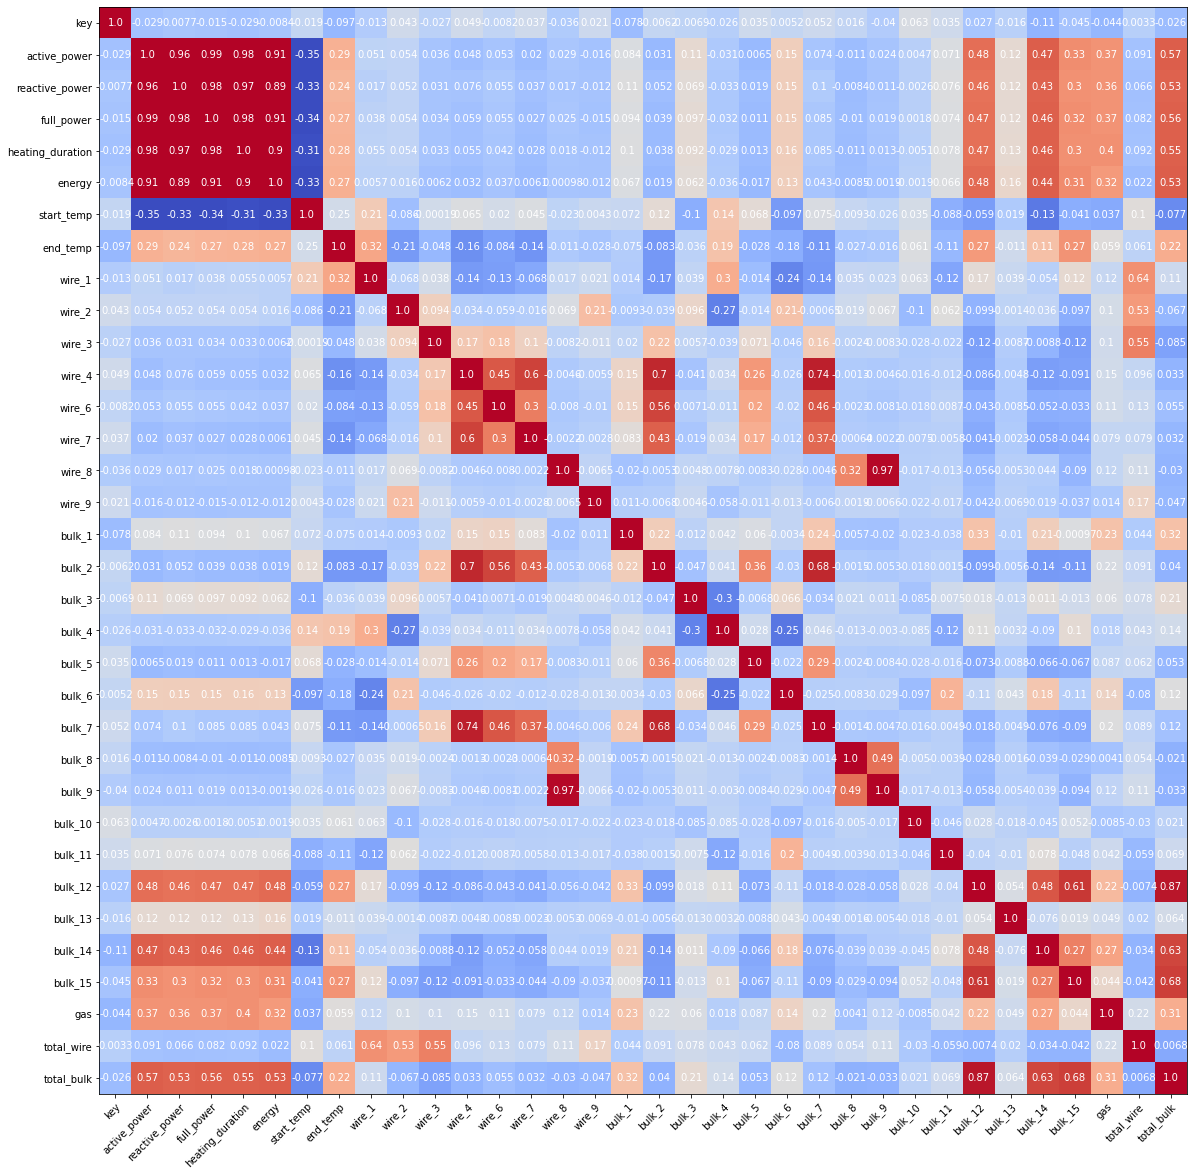

In [ ]:
df.set_index('key')


df_korr = df.copy()
corr_heatmap = df_korr.corr()

fig, ax = plt.subplots(figsize=(20,20))
ax.set_xticks(np.arange(len(corr_heatmap.index)))
ax.set_yticks(np.arange(len(corr_heatmap.index)))

ax.set_xticklabels(corr_heatmap.index)
ax.set_yticklabels(corr_heatmap.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

data = corr_heatmap.values

for i in range(len(corr_heatmap.index)):
    for j in range(len(corr_heatmap.index)):
        text = ax.text(j, i, '{:.2}'.format(data[i, j]), ha="center", va="center", color="w")

im = ax.imshow(corr_heatmap.corr(), cmap= 'coolwarm')

Как видно на тепловой карте, между собой сильно коррелируют активная мощность и реактивная мощность, продолжительность нагрева и полная мощность, bulk_9 и wire_8, bulk_7 и wire_4, bulk_12 и total_bulk

Их высокая корреляция может привести к переобучению моделей, так что оставим полную мощность и bulk_9, total_bulk, whire_4.



In [ ]:
df.drop(columns=['active_power','reactive_power', 'heating_duration', 'wire_8', 'bulk_7', 'bulk_12'], inplace=True)
df.columns

Index(['key', 'full_power', 'energy', 'start_temp', 'end_temp', 'wire_1',
       'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 'wire_9', 'bulk_1',
       'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_8', 'bulk_9',
       'bulk_10', 'bulk_11', 'bulk_13', 'bulk_14', 'bulk_15', 'gas',
       'total_wire', 'total_bulk'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2327
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2328 non-null   int64  
 1   full_power  2328 non-null   float64
 2   energy      2328 non-null   float64
 3   start_temp  2328 non-null   float64
 4   end_temp    2328 non-null   float64
 5   wire_1      2328 non-null   float64
 6   wire_2      2328 non-null   float64
 7   wire_3      2328 non-null   float64
 8   wire_4      2328 non-null   float64
 9   wire_6      2328 non-null   float64
 10  wire_7      2328 non-null   float64
 11  wire_9      2328 non-null   float64
 12  bulk_1      2328 non-null   float64
 13  bulk_2      2328 non-null   float64
 14  bulk_3      2328 non-null   float64
 15  bulk_4      2328 non-null   float64
 16  bulk_5      2328 non-null   float64
 17  bulk_6      2328 non-null   float64
 18  bulk_8      2328 non-null   float64
 19  bulk_9      2328 non-null  

Теперь дополнительно посмотрим, какие столбцы влияют на целевой признак

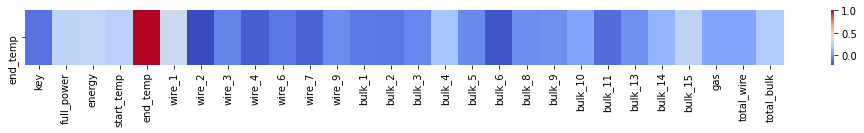

key          -0.096599
full_power    0.273002
energy        0.274599
start_temp    0.252389
end_temp      1.000000
wire_1        0.317362
wire_2       -0.207076
wire_3       -0.047624
wire_4       -0.159821
wire_6       -0.084135
wire_7       -0.137336
wire_9       -0.027553
bulk_1       -0.075401
bulk_2       -0.082532
bulk_3       -0.036365
bulk_4        0.187687
bulk_5       -0.028436
bulk_6       -0.180843
bulk_8       -0.026610
bulk_9       -0.016124
bulk_10       0.061233
bulk_11      -0.114912
bulk_13      -0.010969
bulk_14       0.114991
bulk_15       0.265801
gas           0.059203
total_wire    0.060630
total_bulk    0.222228
Name: end_temp, dtype: float64

In [ ]:
corr = df.corr()

f,ax = plt.subplots(figsize=(17,1))
sns.heatmap(corr.sort_values(by=['end_temp'], ascending=False).head(1), cmap='coolwarm')
plt.show()
display(df.corr()['end_temp'] )

Здесь всё в порядке, слишком сильных зависимостей не наблюдается

### Создание моделей

Разделим данные на выборки: обучающую и тестовую. На тестовую будет приходиться 20%

In [ ]:
random_state = 29082022

df = df.drop(['key'], axis = 1)
X, y = train_test_split(df, test_size = .20, random_state = random_state)

df

,full_power,energy,start_temp,end_temp,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,...,bulk_8,bulk_9,bulk_10,bulk_11,bulk_13,bulk_14,bulk_15,gas,total_wire,total_bulk
0,5.826395,1442.377754,1571.0,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,150.0,154.0,29.749986,60.059998,553.0
1,3.649216,881.233565,1581.0,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,149.0,154.0,12.555561,96.052315,582.0
2,2.989534,525.066777,1596.0,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,152.0,153.0,28.554793,91.160157,544.0
3,3.814962,796.911309,1601.0,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,153.0,154.0,18.841219,89.063515,595.0
4,4.035758,1199.137958,1576.0,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,151.0,152.0,5.413692,98.352796,584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,3.986869,778.818234,1570.0,1591.0,89.150879,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,90.0,0.0,0.0,129.0,223.0,7.125735,89.150879,719.0
2324,5.057033,875.261419,1554.0,1591.0,114.179527,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,122.0,0.0,0.0,129.0,226.0,9.412616,114.179527,796.0
2325,2.885017,556.930349,1571.0,1589.0,94.086723,9.04800,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,124.0,226.0,6.271699,103.134723,665.0
2326,4.143749,767.817794,1591.0,1594.0,118.110717,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,101.0,0.0,0.0,129.0,207.0,14.953657,118.110717,733.0


In [ ]:
X_train = X.drop(['end_temp'], axis = 1)
y_train = X['end_temp']

X_test = y.drop(['end_temp'], axis = 1)
y_test = y['end_temp']

**LinearRegression**

In [ ]:
%%time

lin_r = LinearRegression()
score_lr = (cross_val_score(lin_r, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean())
print('Среднее MAE на обучающей выборке', abs(score_lr))

Среднее MAE на обучающей выборке 6.565678348690336
CPU times: user 303 ms, sys: 502 ms, total: 805 ms
Wall time: 771 ms


<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА 2</b></u></p>Кросс-валидация на работе:) ОК. Здесь, кстати, можно использовать парамтер нормализации. В линейной регрессии часто применяют масштабирование данных.

**CatBoostRegressor**

In [ ]:
%%time
params_cat = {'depth': [3,6, 7, 8],
                  'learning_rate' : [0.005, 0.01, 0.03, 0.05, 0.1, 0.11, 0.12],
                  'iterations'    : [30, 50, 100, 130, 135]
                 }

cat_model = CatBoostRegressor(verbose=False, random_state=random_state)

grid = GridSearchCV(estimator=cat_model, param_grid = params_cat, cv = 5, n_jobs=-1)
grid.fit(X_train, y_train)
best_params_cat = grid.best_params_

predictions = grid.predict(X_train)
score_cat_train = mean_absolute_error(y_train, predictions)

print(best_params_cat)
print('MAE на обучающей выборке', score_cat_train)

{'depth': 7, 'iterations': 135, 'learning_rate': 0.1}
MAE на обучающей выборке 4.359492102809846
CPU times: user 4min 35s, sys: 7.01 s, total: 4min 42s
Wall time: 9min 48s


**LGBMRegressor**

In [ ]:
%%time
params_grid = {'boosting_type' : ['gbdt'],
                  'n_estimators': [500],
                  'learning_rate': [0.01, 0.03, 0.1, 0.2],
                  'max_depth': [3, 5, 7],
                  }

grid_lgbm = GridSearchCV(LGBMRegressor(random_state=random_state), params_grid, cv=5, scoring='neg_mean_absolute_error')
best_params_lgbm = grid_lgbm.fit(X_train, y_train).best_params_
predictions = grid_lgbm.predict(X_train)
score_lgbm_train = mean_absolute_error(y_train, predictions)

print('MAE на обучающей выборке', score_lgbm_train)

MAE на обучающей выборке 4.725731715566856
CPU times: user 2min, sys: 399 ms, total: 2min
Wall time: 2min 1s


### Проверка моделей на тестовой выборке

Протестируем модель CatBoostRegressor на тестовой выборке, она показала наилучший результат. Идеальной оценкой будем считать условие: МАЕ < 6.

**CatBoostRegressor**

In [ ]:
%%time

model = CatBoostRegressor(verbose=False)
model.set_params(**best_params_cat)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
score_cat = mean_absolute_error(predictions, y_test)
print('MAE на тестовой выборке', score_cat)

MAE на тестовой выборке 5.904412612558478
CPU times: user 706 ms, sys: 1.56 ms, total: 708 ms
Wall time: 1.23 s


Этот скор - максимум, что я смогла выжать, сдаюсь 😅

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Получилось улучшить качество
</div>

In [ ]:
importances = model.feature_importances_
feature_list = list(X.columns)

a = {'feature': feature_list,'importance': importances}
feature_results = pd.DataFrame.from_dict(a, orient='index')
feature_results = feature_results.transpose()

feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

Text(0.5, 1.0, 'График важности факторов')

<Figure size 1728x1440 with 0 Axes>

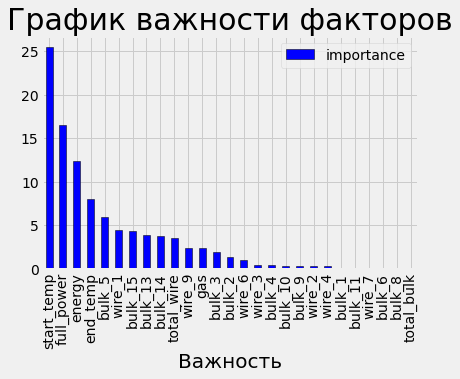

In [ ]:
#plt.rcParams['font.size'] = 30


plt.figure(figsize=(24, 20))

plt.style.use('fivethirtyeight')
feature_results.plot(x = 'feature', y = 'importance',
                                 edgecolor = 'k',
                                 kind='bar', color = 'blue');
plt.xlabel('Важность', size = 20); plt.ylabel('')
plt.title('График важности факторов', size = 30)

Признаки bulk_1, bulk_11, wire_7, bulk_6, bulk_8, total_bulk совсем практически не влияет на модель, от них в дальнейшем можно избавиться

## Вывод

Во втором этапе была проведена предобработка данных:
1. Пропуски в таблицах с сыпучими материалами и с проволоками были заменены на 0
2. Удалены партии с пропущенными температурами, также удалены партии с одинаковой начальной и конечной температурой
3. Удалена партия с аномальным значением реактивной мощности
4. Добавлены дополнительные признаки: полная мощность, энергия, время нагрева в секундах, сумма всех присадок на партию
5. Был проведен анализ на мультиколлинеарность, который показал, что между собой сильно коррелируют активная мощность и реактивная мощность, продолжительность нагрева и полная мощность, bulk_9 и wire_8, bulk_7 и wire_4, bulk_12 и total_bulk. Их высокая корреляция могла бы привести к переобучению моделей, так что мы оставили полную мощность и bulk_9, total_bulk, whire_4.

In [ ]:
index = ['LinearRegression',
         'CatBoostRegressor',
         'LGBMRegressor']
data = {'MAE на обучающей выборке':[abs(score_lr),
                     score_cat_train,
                     score_lgbm_train],
        'MAE на тесте':['-',
                        score_cat,
                        '-']}

scores_df = pd.DataFrame(data=data, index=index)
scores_df

,MAE на обучающей выборке,MAE на тесте
LinearRegression,6.565678,-
CatBoostRegressor,4.359492,5.904413
LGBMRegressor,4.725732,-


Почти идеальный результат показала модель CatBoostRegressor, MAE = 6.01. LGBMRegressor 	показала результат 6.4, а линейная регрессия не использовалась в тестировании на тестовой выборке.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА 3</b></u></p>
Привет, Ольга!<br>
Дааа! Увидел все корректировки, без вопросов. В общем-то всё тогда. Ты молодец!!!!<br>

Всегда стараюсь на этом проекте сказать всем вот ещё что: цель заказчика - экономия энергоресурсов.<br>
И в этом проекте искали как раз способ точно предсказывать температуру. И круто использовали для этого весь арсенал<br>
А если рассудать с позиции такой: а что нужно сделать, чтобы снизить энергопотребление?<br>
Судя по модели, самым важным фактором является первая температура. Это значит, что управляя ею, мы сможем управлять энергозатратами. Вывод понятен. Теперь надо разработать мероприятия для этого решения. И тут вопрос возникает скм собой: а это так точно? мы можем управлять первой температурой? В общем, наша модель - только начало работы над энергоэффективностью.<br>
    
Так же есть ещё одна идея, которую хотел предложить тебе на обсуждение.<br>
Возможно, покажется интересным<br><br>

Дело касается принципиально иного подхода к поиску решения для снижения энергопотребления на производстве<br>
Смотри, Создание данной модели (таково было задание) двигалось по пути "угадывания" температуры<br>
Но мы же знаем жизнь)) лёгкие колебания температур (как и нашего настроения, нашего веса.....)<br>
есть всегда. Более того - будут вегда! И нам что, стараться угадывать их?<br>
Не угонимся, "пупок" развяжется))))) <br>
Предложу для подобных проектов подумать вот в какую сторону<br>
    
Итак, разброс в измерениях - есть, был и будет!! (т.к. этому благоприятствует разнообразие факторов самого проиозводства)<br>
    Тогда задачу можно поставить так: <u>надо уменьшить разброс в измерениях</u>. В данном случае в температуре.<br>
Один из подходов такой: Наверняка есть границы, в пределах которых колебания температур - дело нормальное.<br>
А что, если фикировать случаи, когда температура выходит за эти границы?<br>
Скажем, как "1". И тогда для таких моментов времени собирать инфо по производству: <br>
а что был за материал (химия материала), что был за газ (химический состав газа), какая бригада работала, <br>
что там было с электродами, ограничения только в фантазиях ну и в знаниях самого производства..... <br>
И вот тут можем реально находить причины (через корреляции, проверки гипотез, разные модельки...), фиксировать эти причины. <br>
Ну и разрабатывать энергосберегательные мероприятия.<br><br>
Спасибо за этот труд и за совместную работу на других проектах)<br>
Искренне желаю покорить ещё не один аналитический Эверест)<br>
Тогда остался отчёт. В слаке писал, что в нём важно отразить. БУДУ ЖДАТЬ!

# Отчёт по проекту Промышленность

## Введение

Перед заказчиком, металлургическим комбинатом ООО «Так закаляем сталь», стояла задача - оптимизировать производственные расходы. Было решено это сделать уменьшением потребления электроэнергии на этапе обработки стали. Для этого нам нужно было построить модель, которая предскажет температуру стали. Зная конечную температуру можно заранее рассчитывать количество требуемой энергии и контролировать потребление, не допуская излишней траты энергоресурсов.

### Процесс производства

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

## Данные

Работа велась на данными в формате .csv, полученных из разных источников:  
  
- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).
  
Во всех файлах столбец `key` содержит номер партии. В файлах могло быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Признаки

**Файл `data_arc.csv`**

Это таблица из следущих признаков:
1. `key` - номер партии. В таблице по несколько итераций обработки одной партии, поэтому строк на одну партию может быть несколько. На одну партию приходится в основном 5 итераций.
2. `Начало нагрева дугой` - дата и время, полученные с датчиков, когда начался нагрев продукта графитовыми электродами
3. `Конец нагрева дугой` - дата и время, полученные с датчиков, когда продукт нагрелся до нужной температуры и нагрев прекратился
4. `Активная мощность` - мощность, питающая нагрузку постоянного тока при работе электродов и нагреве
5. `Реактивная мощность`- мощность, которая постоянно перетекает туда и обратно между источником и нагрузкой  
  
  
В этой таблице нет пропущенных данных, но есть неверные типы: дата и время в формате object. Они в дальнейшем будут использоваться в расчётах и такой формат будет препятствовать всем манипуляциям, поэтому я их перевела в нужный формат datetime.

Также в этом файле нашлось аномальное значение признака Реактивной мощности: `-715.504924`, что соответсвует партии `2116`. Теоретически реактивная мощность может быть отрицательным числом, но это значение слишком большое и единственное отрицательное число в датасете, поэтому я определила его как аномалию.

**Файл `data_bulk.csv`**

Признаки:
1. `key` - номер партии
2. `Bulk_X`, где Х - цифра от 1 до 15 - тип сыпучего материала и его объём, который добавляли в ту или иную партию продукта. Всего их 15.   
  
В этой таблице есть пропуски. Природа пропусков - если определённый сыпучий материал не добавлялся в партию, то данные о нём не передавались датчиками.

**Файл `data_bulk_time.csv`**

Признаки:  
1. `key` - номер партии
2. `Bulk_X`, где Х - цифра от 1 до 15 - тип сыпучего материала и время, когда его добавляли в ту или иную партию продукта. Всего их 15.  

Здесь тоже есть пропуски, природа их аналогична: если примесь не используется в производстве партии продукта, то датчики ничего не передают.

**Файл `data_gas.csv`**

Признаки:
1. `key` - номер партии
2. `Газ 1` - объём инертного газа, которым продували сплавы  
  
  
По большей части на партию приходится 9-15 продувок

**Файл `data_temp.csv`**

1. `key` - номер партии.  В таблице по несколько замеров температуры для одной партии, поэтому строк на одну партию может быть несколько. Количество замеров варьируется от 4 до 16, но в основном хватает 5.
2. `Время замера` - дата и время, когда был произведен замер температуры.
3. `Температура` - количество градусов нагрева сплава по Цельсию

Время замера снова в вещественном формате, перевела его в нужный. Есть пропуски в значениях температуры - они встречаются в партиях после 2500. Скорее всего что-то произошло на производстве и датчик перестал исправно передавать данные, нужно его обязательно посмотреть.

**Файл `data_wire.csv`**

1. `key` - номер партии.  
2. `Wire_X` - где Х - цифра от 1 до 9 - тип проволочного материала и его объём, который добавляли в ту или иную партию продукта. Всего их 9.  
  
Система хранения эти признаков аналогична системе хранения объёмов сыпучих материалов. Природа пропусков в признаках такая же: если присадка не добавлялась к сплаву, то датчики информацию о ней не передают

**Файл `data_wire_time`**

1. `key` - номер партии.  
2. `Wire_X` - где Х - цифра от 1 до 9 - тип проволочного материала и тип сыпучего материала и время, когда его добавляли в ту или иную партию продукта. Всего их 9.  
  
Тоже есть пропуске: нет данных там, где проволочный материал к сплаву не добавлялся.

## Алгоритм

### Предобработка данных

Перед предобработкой данных приняла решение не работать с таблицами со временем добавления примесей к продукту, так как данные времени в них указаны некорректно: согласно производственному процессу сначала делается замер температуры материала, а потом уже добавляются примеси, если необходимо, однако по этим данным мы видим, что в некоторых партиях время подачи материала гораздо раньше, чем время замера температуры. Есть вероятность, что дастчики отрабатывают не совсем верно и передают неправильное время, их нужно проверить и откадитбровать.  
  
Начала предобработку с переименования столбцов: перевела их на английский язык, чтобы содели смогли их обработать.

По плану было решено удалить все партии, в которых есть пропуски значений температуры (это от 2500 партии), а также удалить партию 2116, где было аномально низкое значение реативной мощности.  
  
Также обработали пропуски в таблицах с объёмами присадок - заменили все недостающие значения на 0.

Дальше по плану было решено добавить ряд новых признаков на основании текущих.  
  
  
**Полная мощность**

Рассчитывалась как корень из сумм квадратов активной и реактивной мощностей.

<img src="https://samelectrik.ru/wp-content/uploads/2016/11/vybor-stabilizatora-napryazheniya-3.png">

**Время нагрева, когда электроды были активны**

У нас есть время начала нагрева и время конца нагрева, посчитали сколько времени длился нагрев и перевели его в секунды. Признаки с датами удалили, потому что в них уже не было нужды.

**Энергия**  
  
Уже известную полную мощность умножили на время нагрева в секундах

**Первая и последняя температуры**  
  
Из всех замеров температур оставили только первую и последнюю, остальные показания роли не играли. Последняя температура  **целевой признак**, который нужно предсказать.  
  
Планировала сначала также удалить партии, где первая и последняя температуры одинаковы, но не стала в итоге этого делать: такое имеет место быть и если эти данные не удалять, то модели работают лучше.

**Полная масса всех присадок для партии**  
  
После добавления всех остальных признаков мы объединили все таблицы, кроме тех, где было время добавление присадок, методом inner join. Присоединяли все данные к таблице arc. Перед объединением сгруппировали её по столбцу с номерами партий. После преобразований у каждой партии появились признаки суммированного объёма каждого типа присадки, доролнительно добавила два признака общего объёма каждого типа присадок: `total_bulk` и `total_wire`.  
  
После всех манипуляций пришлось удалить 1 признак `Wire 5`, так как он не использовался ни в одной партии. А так после объединения не осталось партий без присадок или без газа, всё было на месте.
  
  
В целом при приобработке удалось следовать намеченному плану.

### Подготовка к моделированию

Первым делом проверили данные на мультиколлинеарность, отобразив всё на тепловой карте для наглядности.

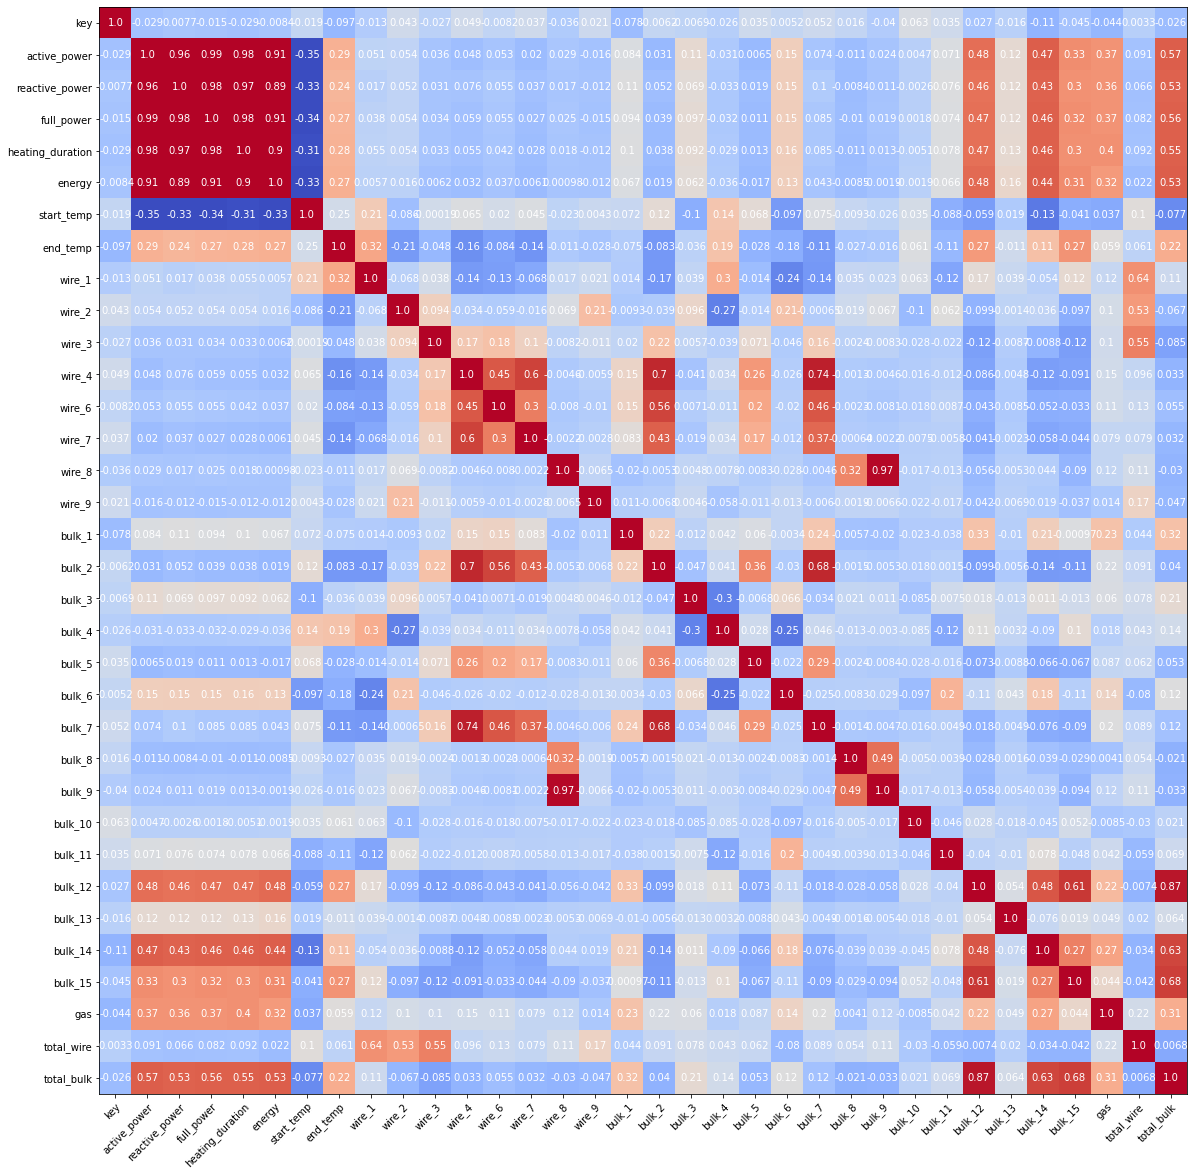

Оказалось, что между собой сильно коррелируют такие признаки как активная мощность и реактивная мощность, продолжительность нагрева и полная мощность, bulk_9 и wire_8, bulk_7 и wire_4, bulk_12 и total_bulk.

Их высокая корреляция могла бы привести к переобучению моделей, поэтому один из пары коррелирующих признаков я решила удалить. Оставила: полную мощность, bulk_9, total_bulk и whire_4.  
  
После обработки отдельно посмотрела, есть влияние на целовой признак - конечную температуру. Сильного влияния оставшихся факторов не наблюдалось, поэтому оставила всё как есть.

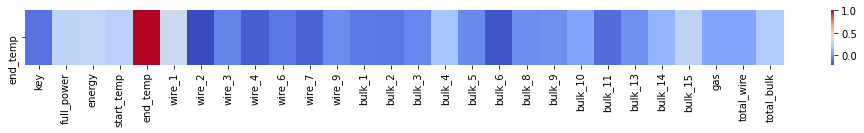

### Моделирование

По плану решила обучить 3 модели: CatBoostRegressor, LGBMRegressor и линейную регрессию.  

Минимально значение `MAE`, которое мы должны были получить должно было быть менее 8.7. В идеале долно было получиться менее 6.

Разделила конечные данные на две выборки: обучающую и тестовую в пропорции 80% на обучающую, 20% на тестовую. Параметр `random_state` взяла равным 29082022.

При обучении модели **линейной регрессии** использовала кроссвалидацию, параметр `cv` взяла равным 5.  
На обучающей выборке эта модель показала результат `MAE` = 6.565. Это лучше, чем минимальное проходное значение, но не дотягивает до идеального.

При обучении **CatBoostRegressor** для подбора параметров использовали GridSearchCV.

Значения параметров модели:
* `depth`: [3,6, 7, 8]
* `learning_rate` : [0.005, 0.01, 0.03, 0.05, 0.1, 0.11, 0.12]
* `iterations`    : [30, 50, 100, 130, 135]
* `cv` = 5
* `n_jobs` = -1  
  
  
На обучающей выборке модель показала очень качественное значение `MAE` - 4.359. Такое качество получилось при подобранных с помощью GridSearchCV параметров: `depth` = 7, `iterations` = 135, `learning_rate` = 0.1

При обучении **LGBMRegressor** для подбора параметров nj;t использовали GridSearchCV.

Значения параметров модели:
* `max_depth`: [3, 5, 7]
* `learning_rate` : [0.01, 0.03, 0.1, 0.2]
* `n_estimators`    : [500]
* `cv` = 5
* `boosting_type` = ['gbdt']
  
  
На обучающей выборке модель показала тоже очень качественное значение `MAE` - 4.725.

Для проверки на тестовой выборке решила взять самую лучшую модель - **CatBoostRegressor**.  
  
  
На вход ей передали параметры наилучшего результата на обучающей выборке. После отработки значение `MAE` на тестовой выборке составило 5.904, что удовлетворяет идеальному условию задачи.

## Заключение

В заключении я решила провести анализ важности признаков и узнать, какие признаки имеют больше влияния на выбранную модель **CatBoostRegressor**, которая на тестовой выборке показала `MAE` = 5.904, а какие можно не использовать в дальнейшем без ущерба качеству.

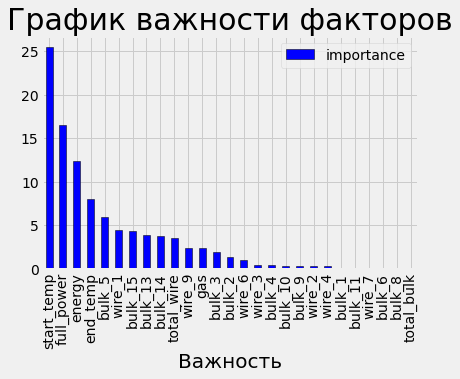

Признаки `bulk_1`, `bulk_11`, `wire_7`, `bulk_6`, `bulk_8`, `total_bulk` совсем практически не влияет на модель, данные по ним можно не передавать модели в дальнейшем.  
  
Самое важное значение имеет начальная температура, полная мощность, энергия, газ и некоторые типа сыпучих и проволочных материалов.  
  
Помним, что в более поздних партиях были пропуски в значениях температуры, а она первостепенна для текущей модели, поэтому рекомендация - обязательно проверить датчик замера на предмет неисправности.